# Strategy 5 - Simple RNN for Price Prediction

Dans ce notebook, nous allons implémenter et tester une stratégie basée sur un RNN simple pour la prédiction des prix. Nous utiliserons la même structure de validation croisée que dans la stratégie 4.

In [1]:
import sys
import os

# Get the parent directory of the "notebook" folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add it to the Python path
sys.path.append(project_root)

In [22]:
from strategies.simple_rnn import SimpleRNNStrategy
from utils.backtest import Backtest
from utils.data_handler import DataHandler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_handler = DataHandler(ticker='AAPL', start_date='2004-12-12', end_date='2015-12-12')
in_sample_data = data_handler.fetch_data()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:


# In-sample training
rnn_strategy = SimpleRNNStrategy(lookback=30, n_splits=5, epochs=30)
rnn_strategy.fit(in_sample_data)  # Only trains once
_ = rnn_strategy.generate_signals(in_sample_data)  # Does not retrain, just generates signals

# Print CV scores after training
print("Cross-validation MSE scores (in-sample):")
for i, score in enumerate(rnn_strategy.cv_scores, 1):
    print(f"Fold {i}: {score:.6f}")
print(f"\nMean MSE: {np.mean(rnn_strategy.cv_scores):.6f}")
print(f"Std MSE: {np.std(rnn_strategy.cv_scores):.6f}")


C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores (in-sample):
Fold 1: 0.000026
Fold 2: 0.000032
Fold 3: 0.000352
Fold 4: 0.000139
Fold 5: 0.000562

Mean MSE: 0.000222
Std MSE: 0.000207


[*********************100%***********************]  1 of 1 completed


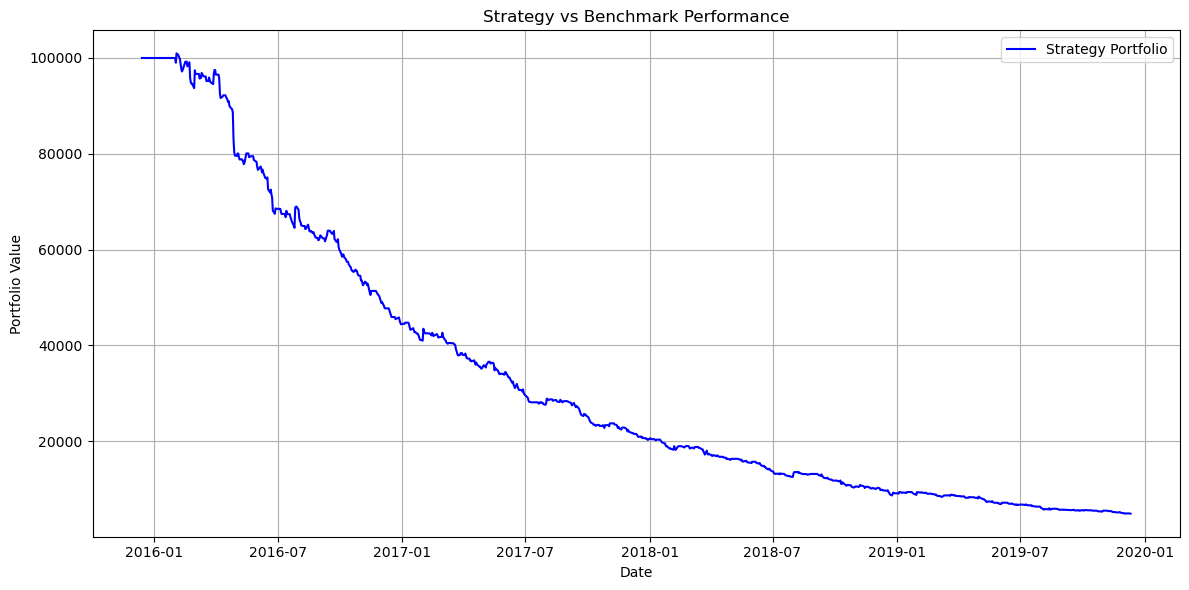


Out-of-sample Backtest Results:
Final Value: 4830.3096
Return: -0.9517
Sharpe Ratio: -3.8546
Max Drawdown: -0.9522


In [6]:
# Backtest on unseen data using the same trained model

data_handler = DataHandler(ticker='AAPL', start_date='2015-12-12', end_date='2019-12-12')
out_sample_data = data_handler.fetch_data()

backtester = Backtest(out_sample_data, rnn_strategy)
results = backtester.run()

# Print results
print("\nOut-of-sample Backtest Results:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")


In [ ]:
# Obtenir les prédictions et les prix réels
X, y = rnn_strategy.prepare_data(data)
predictions = rnn_strategy.generate_prediction(X)

# Inverse transform des données scaled
predictions = rnn_strategy.scaler_X.inverse_transform(predictions)
y_actual = rnn_strategy.scaler_X.inverse_transform(y)

# Création d'un DataFrame pour la visualisation
prediction_index = data.index[rnn_strategy.lookback:]
df_comparison = pd.DataFrame({
    'Actual': y_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=prediction_index)

# Visualisation
plt.figure(figsize=(15, 6))
plt.plot(df_comparison.index, df_comparison['Actual'], label='Real Prices', alpha=0.8)
plt.plot(df_comparison.index, df_comparison['Predicted'], label='Predicted Prices', alpha=0.6)
plt.title('Real vs Predicted Prices - Simple RNN')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Calcul des métriques
mse = mean_squared_error(df_comparison['Actual'], df_comparison['Predicted'])
r2 = r2_score(df_comparison['Actual'], df_comparison['Predicted'])

print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.4f}')

## Analyse des résultats

Comparaison avec la stratégie basée sur les indicateurs techniques :
1. Performance globale
2. Stabilité des prédictions (std des CV scores)
3. Ratio de Sharpe et drawdown maximum

Points clés à noter :
- Le RNN simple utilise uniquement les prix de clôture passés
- La fenêtre glissante de 30 jours capture les dépendances temporelles
- Les signaux sont générés en comparant les prédictions aux prix actuels

## Backtesting sur 100 Stocks

In [16]:
in_sample_start = "2004-12-31"
in_sample_end = '2015-12-30'
out_sample_start = '2015-12-31'
out_sample_end = '2019-12-31'

tickers = [
    "AAPL", "ABT", "ADI", "ADM", "ADP", "ADSK", "AEE", "AEP", "AJG", "AKAM",
    "ALB", "AMAT", "AMD", "AME", "AMGN", "AMT", "AMZN", "AON", "AOS", "APA",
    "APD", "APH", "ARE", "AVB", "AVY", "AXP", "AZO", "BA", "BAC", "BAX",
    "BBY", "BDX", "BEN", "BIIB", "BK", "BLK", "BMY", "BSX", "BXP", "C",
    "CAG", "CAH", "CAT", "CB", "CCI", "CDNS", "CHD", "CHRW", "CINF", "CL",
    "CLX", "CMI", "CNP", "COO", "COP", "COST", "CPB", "CPRT", "CSCO", "CTAS",
    "CTSH", "D", "DE", "DGX", "DHI", "DIS", "DLTR", "DOV", "DRI", "DTE",
    "DVA", "EA", "EBAY", "ECL", "ED", "EFX", "EIX", "EL", "EMN", "EMR",
    "EOG", "EQR", "ES", "ESS", "F", "FAST", "FCX", "FDX", "FE", "FFIV",
    "FITB", "FRT", "GD", "GE", "GILD", "GIS", "GPC", "GWW", "HAL", "HAS"
] 

initial_cash = 100000
performance_summary = []
portfolio_series_list = []

for ticker in tickers:
    try:
        # Fetch data
        full_data_handler = DataHandler(ticker=ticker, start_date=in_sample_start, end_date=out_sample_end)
        full_data = full_data_handler.fetch_data()

        # Split data into in-sample and out-of-sample
        in_sample_data = full_data[full_data.index <= in_sample_end]
        out_sample_data = full_data[(full_data.index >= out_sample_start) & (full_data.index <= out_sample_end)]

        if len(in_sample_data) < 100 or len(out_sample_data) < 100:
            print(f"Skipping {ticker} due to insufficient data.")
            continue

        # Train RNN strategy on in-sample data
        rnn_strategy = SimpleRNNStrategy(lookback=30, n_splits=5, epochs=30)
        rnn_strategy.fit(in_sample_data)  # Train only once

        # Generate in-sample signals for evaluation (optional, if you want to print MSE on in-sample data)
        rnn_strategy.generate_signals(in_sample_data)
        print(f"Cross-validation MSE scores for {ticker} (in-sample):")
        for i, score in enumerate(rnn_strategy.cv_scores, 1):
            print(f"Fold {i}: {score:.6f}")
        print(f"\nMean MSE: {np.mean(rnn_strategy.cv_scores):.6f}")
        print(f"Std MSE: {np.std(rnn_strategy.cv_scores):.6f}")

        # Backtest on out-of-sample data using the trained model
        backtest = Backtest(out_sample_data, rnn_strategy, initial_cash=initial_cash, plot_results=False)
        metrics = backtest.run()
        portfolio_series = backtest.get_portfolio_value_series()

        # Append performance results
        performance_summary.append({
            'Ticker': ticker,
            **metrics
        })
        portfolio_series_list.append(portfolio_series.rename(ticker))

    except Exception as e:
        print(f"Error processing {ticker}: {e}")

[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for AAPL (in-sample):
Fold 1: 0.000025
Fold 2: 0.000035
Fold 3: 0.000422
Fold 4: 0.000150
Fold 5: 0.000282

Mean MSE: 0.000183
Std MSE: 0.000151


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.7139016723667737' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for ABT (in-sample):
Fold 1: 0.000096
Fold 2: 0.000116
Fold 3: 0.000044
Fold 4: 0.000198
Fold 5: 0.000835

Mean MSE: 0.000258
Std MSE: 0.000293


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16.204755210870644' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for ADI (in-sample):
Fold 1: 0.000194
Fold 2: 0.000113
Fold 3: 0.000283
Fold 4: 0.000213
Fold 5: 0.000363

Mean MSE: 0.000233
Std MSE: 0.000084


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.396573486330453' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for ADM (in-sample):
Fold 1: 0.000727
Fold 2: 0.000396
Fold 3: 0.000183
Fold 4: 0.000176
Fold 5: 0.000917

Mean MSE: 0.000479
Std MSE: 0.000297


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '25.400456066126935' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for ADP (in-sample):
Fold 1: 0.000123
Fold 2: 0.000084
Fold 3: 0.000251
Fold 4: 0.001084
Fold 5: 0.001140

Mean MSE: 0.000536
Std MSE: 0.000474


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '26.827374267581035' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for ADSK (in-sample):
Fold 1: 0.001223
Fold 2: 0.000305
Fold 3: 0.000589
Fold 4: 0.000429
Fold 5: 0.000399

Mean MSE: 0.000589
Std MSE: 0.000330


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '23.06322250366793' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for AEE (in-sample):
Fold 1: 0.000631
Fold 2: 0.000364
Fold 3: 0.000144
Fold 4: 0.000128
Fold 5: 0.000621

Mean MSE: 0.000378
Std MSE: 0.000219


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.903591918948223' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for AEP (in-sample):
Fold 1: 0.000215
Fold 2: 0.000152
Fold 3: 0.000077
Fold 4: 0.000459
Fold 5: 0.000892

Mean MSE: 0.000359
Std MSE: 0.000296


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.141778945922852' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for AJG (in-sample):
Fold 1: 0.000104
Fold 2: 0.000234
Fold 3: 0.000339
Fold 4: 0.000335
Fold 5: 0.000242

Mean MSE: 0.000251
Std MSE: 0.000086


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '24.885664062501746' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for AKAM (in-sample):
Fold 1: 0.001277
Fold 2: 0.000298
Fold 3: 0.000275
Fold 4: 0.000398
Fold 5: 0.000513

Mean MSE: 0.000552
Std MSE: 0.000372


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22.667627868650015' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for ALB (in-sample):
Fold 1: 0.000501
Fold 2: 0.000244
Fold 3: 0.000622
Fold 4: 0.000331
Fold 5: 0.000441

Mean MSE: 0.000428
Std MSE: 0.000131


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10.338137168888352' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for AMAT (in-sample):
Fold 1: 0.000486
Fold 2: 0.001005
Fold 3: 0.000578
Fold 4: 0.000210
Fold 5: 0.000599

Mean MSE: 0.000576
Std MSE: 0.000256


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.6842732429504395' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for AMD (in-sample):
Fold 1: 0.000283
Fold 2: 0.000105
Fold 3: 0.000061
Fold 4: 0.000024
Fold 5: 0.000016

Mean MSE: 0.000098
Std MSE: 0.000098


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9112548232078552' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for AME (in-sample):
Fold 1: 0.000171
Fold 2: 0.000126
Fold 3: 0.000565
Fold 4: 0.000363
Fold 5: 0.000513

Mean MSE: 0.000348
Std MSE: 0.000176


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '17.05730102538655' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for AMGN (in-sample):
Fold 1: 0.000220
Fold 2: 0.000237
Fold 3: 0.000033
Fold 4: 0.000785
Fold 5: 0.000721

Mean MSE: 0.000399
Std MSE: 0.000298


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '94.46590423583984' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for AMT (in-sample):
Fold 1: 0.000189
Fold 2: 0.000203
Fold 3: 0.000149
Fold 4: 0.000438
Fold 5: 0.000349

Mean MSE: 0.000265
Std MSE: 0.000110


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.9164862060570158' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for AMZN (in-sample):
Fold 1: 0.000026
Fold 2: 0.000035
Fold 3: 0.000059
Fold 4: 0.000272
Fold 5: 0.000447

Mean MSE: 0.000168
Std MSE: 0.000167


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '26.919412937160814' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for AON (in-sample):
Fold 1: 0.000233
Fold 2: 0.000228
Fold 3: 0.000088
Fold 4: 0.000335
Fold 5: 0.000372

Mean MSE: 0.000251
Std MSE: 0.000099


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '43.209205627441406' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for AOS (in-sample):
Fold 1: 0.000023
Fold 2: 0.000041
Fold 3: 0.000040
Fold 4: 0.000707
Fold 5: 0.000326

Mean MSE: 0.000227
Std MSE: 0.000265


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '28.84527832031017' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for APA (in-sample):
Fold 1: 0.020183
Fold 2: 0.000820
Fold 3: 0.000525
Fold 4: 0.000146
Fold 5: 0.000218

Mean MSE: 0.004378
Std MSE: 0.007906


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '24.320020294195274' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for APD (in-sample):
Fold 1: 0.001502
Fold 2: 0.000236
Fold 3: 0.000126
Fold 4: 0.000130
Fold 5: 0.000472

Mean MSE: 0.000493
Std MSE: 0.000520


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '46.340103912356426' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for APH (in-sample):
Fold 1: 0.000186
Fold 2: 0.000165
Fold 3: 0.000139
Fold 4: 0.000106
Fold 5: 0.000521

Mean MSE: 0.000224
Std MSE: 0.000151


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.8292037582432386' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for ARE (in-sample):
Fold 1: 0.000527
Fold 2: 0.001182
Fold 3: 0.000357
Fold 4: 0.000114
Fold 5: 0.000429

Mean MSE: 0.000522
Std MSE: 0.000357


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.061377449033898' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for AVB (in-sample):
Fold 1: 0.001189
Fold 2: 0.000261
Fold 3: 0.000151
Fold 4: 0.000304
Fold 5: 0.000379

Mean MSE: 0.000457
Std MSE: 0.000373


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '115.90739852904517' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for AVY (in-sample):
Fold 1: 0.000260
Fold 2: 0.001341
Fold 3: 0.000215
Fold 4: 0.000263
Fold 5: 0.000819

Mean MSE: 0.000580
Std MSE: 0.000441


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '39.685394287109375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for AXP (in-sample):
Fold 1: 0.000723
Fold 2: 0.000347
Fold 3: 0.000093
Fold 4: 0.001492
Fold 5: 0.000202

Mean MSE: 0.000571
Std MSE: 0.000507


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '23.56065551757638' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for AZO (in-sample):
Fold 1: 0.000040
Fold 2: 0.000060
Fold 3: 0.000054
Fold 4: 0.000278
Fold 5: 0.000167

Mean MSE: 0.000120
Std MSE: 0.000091


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '191.80030822753906' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for BA (in-sample):
Fold 1: 0.000199
Fold 2: 0.000334
Fold 3: 0.000090
Fold 4: 0.000645
Fold 5: 0.000467

Mean MSE: 0.000347
Std MSE: 0.000196


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '88.74093986510707' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for BAC (in-sample):
Fold 1: 0.001664
Fold 2: 0.001318
Fold 3: 0.000081
Fold 4: 0.000085
Fold 5: 0.000052

Mean MSE: 0.000640
Std MSE: 0.000703


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6658346652984619' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for BAX (in-sample):
Fold 1: 0.000697
Fold 2: 0.000757
Fold 3: 0.000246
Fold 4: 0.001402
Fold 5: 0.000294

Mean MSE: 0.000679
Std MSE: 0.000416


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '26.611969451900222' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for BBY (in-sample):
Fold 1: 0.000881
Fold 2: 0.000844
Fold 3: 0.000408
Fold 4: 0.000572
Fold 5: 0.000422

Mean MSE: 0.000625
Std MSE: 0.000202


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7.857566242222674' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for BDX (in-sample):
Fold 1: 0.000065
Fold 2: 0.000129
Fold 3: 0.000122
Fold 4: 0.000442
Fold 5: 0.001753

Mean MSE: 0.000502
Std MSE: 0.000639


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '87.76235595703474' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for BEN (in-sample):
Fold 1: 0.000639
Fold 2: 0.000497
Fold 3: 0.000333
Fold 4: 0.000801
Fold 5: 0.000472

Mean MSE: 0.000548
Std MSE: 0.000159


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.531874160762527' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for BIIB (in-sample):
Fold 1: 0.000037
Fold 2: 0.000013
Fold 3: 0.000036
Fold 4: 0.000256
Fold 5: 0.000460

Mean MSE: 0.000160
Std MSE: 0.000174


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '202.7103302001924' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for BK (in-sample):
Fold 1: 0.005192
Fold 2: 0.002589
Fold 3: 0.000403
Fold 4: 0.000407
Fold 5: 0.000710

Mean MSE: 0.001860
Std MSE: 0.001854


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.369027404783992' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for BLK (in-sample):
Fold 1: 0.001204
Fold 2: 0.000489
Fold 3: 0.000118
Fold 4: 0.001342
Fold 5: 0.000315

Mean MSE: 0.000694
Std MSE: 0.000489


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '41.64599884033669' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for BMY (in-sample):
Fold 1: 0.000134
Fold 2: 0.000059
Fold 3: 0.000304
Fold 4: 0.000191
Fold 5: 0.001037

Mean MSE: 0.000345
Std MSE: 0.000355


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.798991165152984' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for BSX (in-sample):
Fold 1: 0.000205
Fold 2: 0.000264
Fold 3: 0.000043
Fold 4: 0.000046
Fold 5: 0.000136

Mean MSE: 0.000139
Std MSE: 0.000087


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.000489082332933' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for BXP (in-sample):
Fold 1: 0.000488
Fold 2: 0.000385
Fold 3: 0.000167
Fold 4: 0.000251
Fold 5: 0.002108

Mean MSE: 0.000680
Std MSE: 0.000723


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11.589806823729305' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for C (in-sample):
Fold 1: 0.001549
Fold 2: 0.000368
Fold 3: 0.000008
Fold 4: 0.000005
Fold 5: 0.000008

Mean MSE: 0.000388
Std MSE: 0.000597


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.331797657010611' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for CAG (in-sample):
Fold 1: 0.000151
Fold 2: 0.000115
Fold 3: 0.000130
Fold 4: 0.000365
Fold 5: 0.000302

Mean MSE: 0.000213
Std MSE: 0.000101


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.044477519986685' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for CAH (in-sample):
Fold 1: 0.000227
Fold 2: 0.000390
Fold 3: 0.000135
Fold 4: 0.000271
Fold 5: 0.000862

Mean MSE: 0.000377
Std MSE: 0.000256


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '28.343179512026836' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for CAT (in-sample):
Fold 1: 0.000266
Fold 2: 0.000413
Fold 3: 0.001168
Fold 4: 0.000216
Fold 5: 0.000269

Mean MSE: 0.000466
Std MSE: 0.000357


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16.944747886649566' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for CB (in-sample):
Fold 1: 0.000270
Fold 2: 0.000255
Fold 3: 0.000143
Fold 4: 0.000102
Fold 5: 0.000899

Mean MSE: 0.000334
Std MSE: 0.000290


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '69.86173339842935' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for CCI (in-sample):
Fold 1: 0.000220
Fold 2: 0.000168
Fold 3: 0.000148
Fold 4: 0.000611
Fold 5: 0.000187

Mean MSE: 0.000267
Std MSE: 0.000174


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0257355880748946' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for CDNS (in-sample):
Fold 1: 0.002664
Fold 2: 0.000198
Fold 3: 0.000121
Fold 4: 0.000109
Fold 5: 0.000319

Mean MSE: 0.000682
Std MSE: 0.000994


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.19935829161840957' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for CHD (in-sample):
Fold 1: 0.000037
Fold 2: 0.000039
Fold 3: 0.000075
Fold 4: 0.000533
Fold 5: 0.001123

Mean MSE: 0.000362
Std MSE: 0.000425


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '17.37526855469332' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for CHRW (in-sample):
Fold 1: 0.000993
Fold 2: 0.000820
Fold 3: 0.001027
Fold 4: 0.000448
Fold 5: 0.000425

Mean MSE: 0.000743
Std MSE: 0.000260


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '43.71516113281541' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for CINF (in-sample):
Fold 1: 0.000443
Fold 2: 0.000382
Fold 3: 0.000161
Fold 4: 0.000309
Fold 5: 0.000287

Mean MSE: 0.000317
Std MSE: 0.000096


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22.29985462188779' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for CL (in-sample):
Fold 1: 0.000084
Fold 2: 0.000281
Fold 3: 0.000304
Fold 4: 0.000212
Fold 5: 0.000186

Mean MSE: 0.000213
Std MSE: 0.000077


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '53.17095016480016' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for CLX (in-sample):
Fold 1: 0.000050
Fold 2: 0.000075
Fold 3: 0.000060
Fold 4: 0.000178
Fold 5: 0.000464

Mean MSE: 0.000165
Std MSE: 0.000156


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '87.66582679748535' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for CMI (in-sample):
Fold 1: 0.001633
Fold 2: 0.000137
Fold 3: 0.000363
Fold 4: 0.000618
Fold 5: 0.000185

Mean MSE: 0.000587
Std MSE: 0.000550


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '57.73594642638636' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for CNP (in-sample):
Fold 1: 0.000172
Fold 2: 0.000233
Fold 3: 0.000510
Fold 4: 0.000458
Fold 5: 0.000245

Mean MSE: 0.000324
Std MSE: 0.000134


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.439546413414064' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for COO (in-sample):
Fold 1: 0.000090
Fold 2: 0.000046
Fold 3: 0.000109
Fold 4: 0.000159
Fold 5: 0.000281

Mean MSE: 0.000137
Std MSE: 0.000080


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.621933593749418' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for COP (in-sample):
Fold 1: 0.001089
Fold 2: 0.000345
Fold 3: 0.000225
Fold 4: 0.000179
Fold 5: 0.000854

Mean MSE: 0.000538
Std MSE: 0.000366


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '21.582697753910907' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for COST (in-sample):
Fold 1: 0.000067
Fold 2: 0.000046
Fold 3: 0.000050
Fold 4: 0.000237
Fold 5: 0.001410

Mean MSE: 0.000362
Std MSE: 0.000529


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '121.71349609375466' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for CPB (in-sample):
Fold 1: 0.000330
Fold 2: 0.000188
Fold 3: 0.000137
Fold 4: 0.000968
Fold 5: 0.000525

Mean MSE: 0.000430
Std MSE: 0.000301


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16.73953384399647' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for CPRT (in-sample):
Fold 1: 0.000472
Fold 2: 0.000321
Fold 3: 0.000163
Fold 4: 0.000702
Fold 5: 0.000200

Mean MSE: 0.000372
Std MSE: 0.000197


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2787499999976717' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for CSCO (in-sample):
Fold 1: 0.001247
Fold 2: 0.000762
Fold 3: 0.000554
Fold 4: 0.000387
Fold 5: 0.000543

Mean MSE: 0.000699
Std MSE: 0.000299


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16.10678894042212' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for CTAS (in-sample):
Fold 1: 0.000179
Fold 2: 0.000131
Fold 3: 0.000077
Fold 4: 0.000416
Fold 5: 0.001752

Mean MSE: 0.000511
Std MSE: 0.000631


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.080929279327393' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for CTSH (in-sample):
Fold 1: 0.000149
Fold 2: 0.000118
Fold 3: 0.000162
Fold 4: 0.000205
Fold 5: 0.000323

Mean MSE: 0.000191
Std MSE: 0.000072


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '18.52868297576788' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for D (in-sample):
Fold 1: 0.000164
Fold 2: 0.000194
Fold 3: 0.000318
Fold 4: 0.000134
Fold 5: 0.000260

Mean MSE: 0.000214
Std MSE: 0.000067


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11.99352325439395' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for DE (in-sample):
Fold 1: 0.001143
Fold 2: 0.000585
Fold 3: 0.000638
Fold 4: 0.000169
Fold 5: 0.000389

Mean MSE: 0.000585
Std MSE: 0.000324


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '28.693129501334624' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for DGX (in-sample):
Fold 1: 0.000726
Fold 2: 0.000786
Fold 3: 0.000351
Fold 4: 0.000260
Fold 5: 0.001375

Mean MSE: 0.000700
Std MSE: 0.000395


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '19.521688079839805' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for DHI (in-sample):
Fold 1: 0.000855
Fold 2: 0.000261
Fold 3: 0.000102
Fold 4: 0.000538
Fold 5: 0.000249

Mean MSE: 0.000401
Std MSE: 0.000267


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7.029541854863055' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for DIS (in-sample):
Fold 1: 0.000039
Fold 2: 0.000097
Fold 3: 0.000047
Fold 4: 0.000177
Fold 5: 0.000306

Mean MSE: 0.000133
Std MSE: 0.000099


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '62.49030227660842' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for DLTR (in-sample):
Fold 1: 0.000021
Fold 2: 0.000040
Fold 3: 0.000906
Fold 4: 0.000160
Fold 5: 0.000447

Mean MSE: 0.000315
Std MSE: 0.000332


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '27.934527587887715' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for DOV (in-sample):
Fold 1: 0.000098
Fold 2: 0.000203
Fold 3: 0.000372
Fold 4: 0.000454
Fold 5: 0.000292

Mean MSE: 0.000284
Std MSE: 0.000125


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '19.604158210757305' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for DRI (in-sample):
Fold 1: 0.000296
Fold 2: 0.000507
Fold 3: 0.000215
Fold 4: 0.000436
Fold 5: 0.000301

Mean MSE: 0.000351
Std MSE: 0.000105


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '41.62944316864014' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for DTE (in-sample):
Fold 1: 0.000105
Fold 2: 0.000120
Fold 3: 0.000083
Fold 4: 0.000405
Fold 5: 0.000896

Mean MSE: 0.000322
Std MSE: 0.000310


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '23.73791332244582' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for DVA (in-sample):
Fold 1: 0.000067
Fold 2: 0.000100
Fold 3: 0.000168
Fold 4: 0.000381
Fold 5: 0.000496

Mean MSE: 0.000243
Std MSE: 0.000167


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '55.496110839842004' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for EA (in-sample):
Fold 1: 0.000610
Fold 2: 0.002687
Fold 3: 0.000090
Fold 4: 0.000152
Fold 5: 0.000397

Mean MSE: 0.000787
Std MSE: 0.000968


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '44.01649978637579' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for EBAY (in-sample):
Fold 1: 0.000144
Fold 2: 0.000317
Fold 3: 0.000178
Fold 4: 0.000698
Fold 5: 0.000501

Mean MSE: 0.000368
Std MSE: 0.000208


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2165053176868241' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for ECL (in-sample):
Fold 1: 0.000048
Fold 2: 0.000197
Fold 3: 0.000198
Fold 4: 0.000306
Fold 5: 0.000293

Mean MSE: 0.000209
Std MSE: 0.000093


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '79.52025138854515' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for ED (in-sample):
Fold 1: 0.000087
Fold 2: 0.000148
Fold 3: 0.000912
Fold 4: 0.000253
Fold 5: 0.000288

Mean MSE: 0.000337
Std MSE: 0.000296


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '46.00242523192719' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for EFX (in-sample):
Fold 1: 0.000109
Fold 2: 0.000097
Fold 3: 0.000045
Fold 4: 0.000155
Fold 5: 0.001458

Mean MSE: 0.000373
Std MSE: 0.000544


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '81.2658287048398' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for EIX (in-sample):
Fold 1: 0.001095
Fold 2: 0.000320
Fold 3: 0.000109
Fold 4: 0.000562
Fold 5: 0.000495

Mean MSE: 0.000516
Std MSE: 0.000329


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.976206588748028' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for EL (in-sample):
Fold 1: 0.000220
Fold 2: 0.000077
Fold 3: 0.000196
Fold 4: 0.002021
Fold 5: 0.000522

Mean MSE: 0.000607
Std MSE: 0.000722


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22.714362869257457' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for EMN (in-sample):
Fold 1: 0.000217
Fold 2: 0.000198
Fold 3: 0.000217
Fold 4: 0.000838
Fold 5: 0.000336

Mean MSE: 0.000361
Std MSE: 0.000243


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '36.921675910954946' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for EMR (in-sample):
Fold 1: 0.000681
Fold 2: 0.000734
Fold 3: 0.000598
Fold 4: 0.000429
Fold 5: 0.000361

Mean MSE: 0.000560
Std MSE: 0.000144


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.84555896758684' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for EOG (in-sample):
Fold 1: 0.000465
Fold 2: 0.000305
Fold 3: 0.000107
Fold 4: 0.000563
Fold 5: 0.000525

Mean MSE: 0.000393
Std MSE: 0.000168


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '44.21287540435151' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for EQR (in-sample):
Fold 1: 0.000301
Fold 2: 0.000320
Fold 3: 0.000155
Fold 4: 0.000224
Fold 5: 0.000811

Mean MSE: 0.000362
Std MSE: 0.000232


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '43.031635742183425' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for ES (in-sample):
Fold 1: 0.000063
Fold 2: 0.000128
Fold 3: 0.000157
Fold 4: 0.000174
Fold 5: 0.000398

Mean MSE: 0.000184
Std MSE: 0.000113


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11.843000335691613' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for ESS (in-sample):
Fold 1: 0.000196
Fold 2: 0.000176
Fold 3: 0.000138
Fold 4: 0.000080
Fold 5: 0.001322

Mean MSE: 0.000382
Std MSE: 0.000472


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '95.82928710937267' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for F (in-sample):
Fold 1: 0.000973
Fold 2: 0.000480
Fold 3: 0.000622
Fold 4: 0.000259
Fold 5: 0.000290

Mean MSE: 0.000525
Std MSE: 0.000260


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.2182813644467387' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for FAST (in-sample):
Fold 1: 0.000221
Fold 2: 0.000201
Fold 3: 0.001397
Fold 4: 0.000415
Fold 5: 0.000288

Mean MSE: 0.000504
Std MSE: 0.000453


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.830998497011024' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for FCX (in-sample):
Fold 1: 0.005800
Fold 2: 0.000763
Fold 3: 0.000595
Fold 4: 0.000616
Fold 5: 0.000203

Mean MSE: 0.001595
Std MSE: 0.002110


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.392963004109333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for FDX (in-sample):
Fold 1: 0.000309
Fold 2: 0.000253
Fold 3: 0.000291
Fold 4: 0.000253
Fold 5: 0.000196

Mean MSE: 0.000261
Std MSE: 0.000039


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '109.61653610228677' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for FE (in-sample):
Fold 1: 0.007179
Fold 2: 0.000645
Fold 3: 0.000189
Fold 4: 0.000201
Fold 5: 0.000193

Mean MSE: 0.001681
Std MSE: 0.002754


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10.254106636042707' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for FFIV (in-sample):
Fold 1: 0.000244
Fold 2: 0.000203
Fold 3: 0.001546
Fold 4: 0.000613
Fold 5: 0.000337

Mean MSE: 0.000589
Std MSE: 0.000500


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '90.08976669311232' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for FITB (in-sample):
Fold 1: 0.006488
Fold 2: 0.001145
Fold 3: 0.000139
Fold 4: 0.000035
Fold 5: 0.000108

Mean MSE: 0.001583
Std MSE: 0.002486


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.760320510860765' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for FRT (in-sample):
Fold 1: 0.000256
Fold 2: 0.000496
Fold 3: 0.000120
Fold 4: 0.000105
Fold 5: 0.000532

Mean MSE: 0.000302
Std MSE: 0.000181


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '90.09771896361781' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for GD (in-sample):
Fold 1: 0.000196
Fold 2: 0.000179
Fold 3: 0.000205
Fold 4: 0.000151
Fold 5: 0.000258

Mean MSE: 0.000198
Std MSE: 0.000035


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.061943817141582' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for GE (in-sample):
Fold 1: 0.001795
Fold 2: 0.000773
Fold 3: 0.000116
Fold 4: 0.000347
Fold 5: 0.000161

Mean MSE: 0.000639
Std MSE: 0.000623


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '70.62989807128906' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for GILD (in-sample):
Fold 1: 0.000076
Fold 2: 0.000034
Fold 3: 0.000040
Fold 4: 0.000946
Fold 5: 0.001710

Mean MSE: 0.000561
Std MSE: 0.000671


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '20.892568588256836' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for GIS (in-sample):
Fold 1: 0.000085
Fold 2: 0.000217
Fold 3: 0.000099
Fold 4: 0.000369
Fold 5: 0.000359

Mean MSE: 0.000226
Std MSE: 0.000122


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '13.250767974852351' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for GPC (in-sample):
Fold 1: 0.000050
Fold 2: 0.000107
Fold 3: 0.000325
Fold 4: 0.000120
Fold 5: 0.000693

Mean MSE: 0.000259
Std MSE: 0.000236


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '31.014522094730637' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for GWW (in-sample):
Fold 1: 0.000077
Fold 2: 0.000075
Fold 3: 0.000597
Fold 4: 0.000357
Fold 5: 0.000224

Mean MSE: 0.000266
Std MSE: 0.000196


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '131.59997146605747' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for HAL (in-sample):
Fold 1: 0.000655
Fold 2: 0.000254
Fold 3: 0.000603
Fold 4: 0.000476
Fold 5: 0.000378

Mean MSE: 0.000473
Std MSE: 0.000146


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.8335247802751837' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost
[*********************100%***********************]  1 of 1 completed
C:\Users\Gautier Pellerin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross-validation MSE scores for HAS (in-sample):
Fold 1: 0.000113
Fold 2: 0.000134
Fold 3: 0.000067
Fold 4: 0.000187
Fold 5: 0.002656

Mean MSE: 0.000631
Std MSE: 0.001013


C:\Users\Gautier Pellerin\Documents\Code\AMP_Algorithmic_Trading\utils\backtest.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.079012489324668' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.portfolio.at[self.data.index[i], 'cash'] -= cost


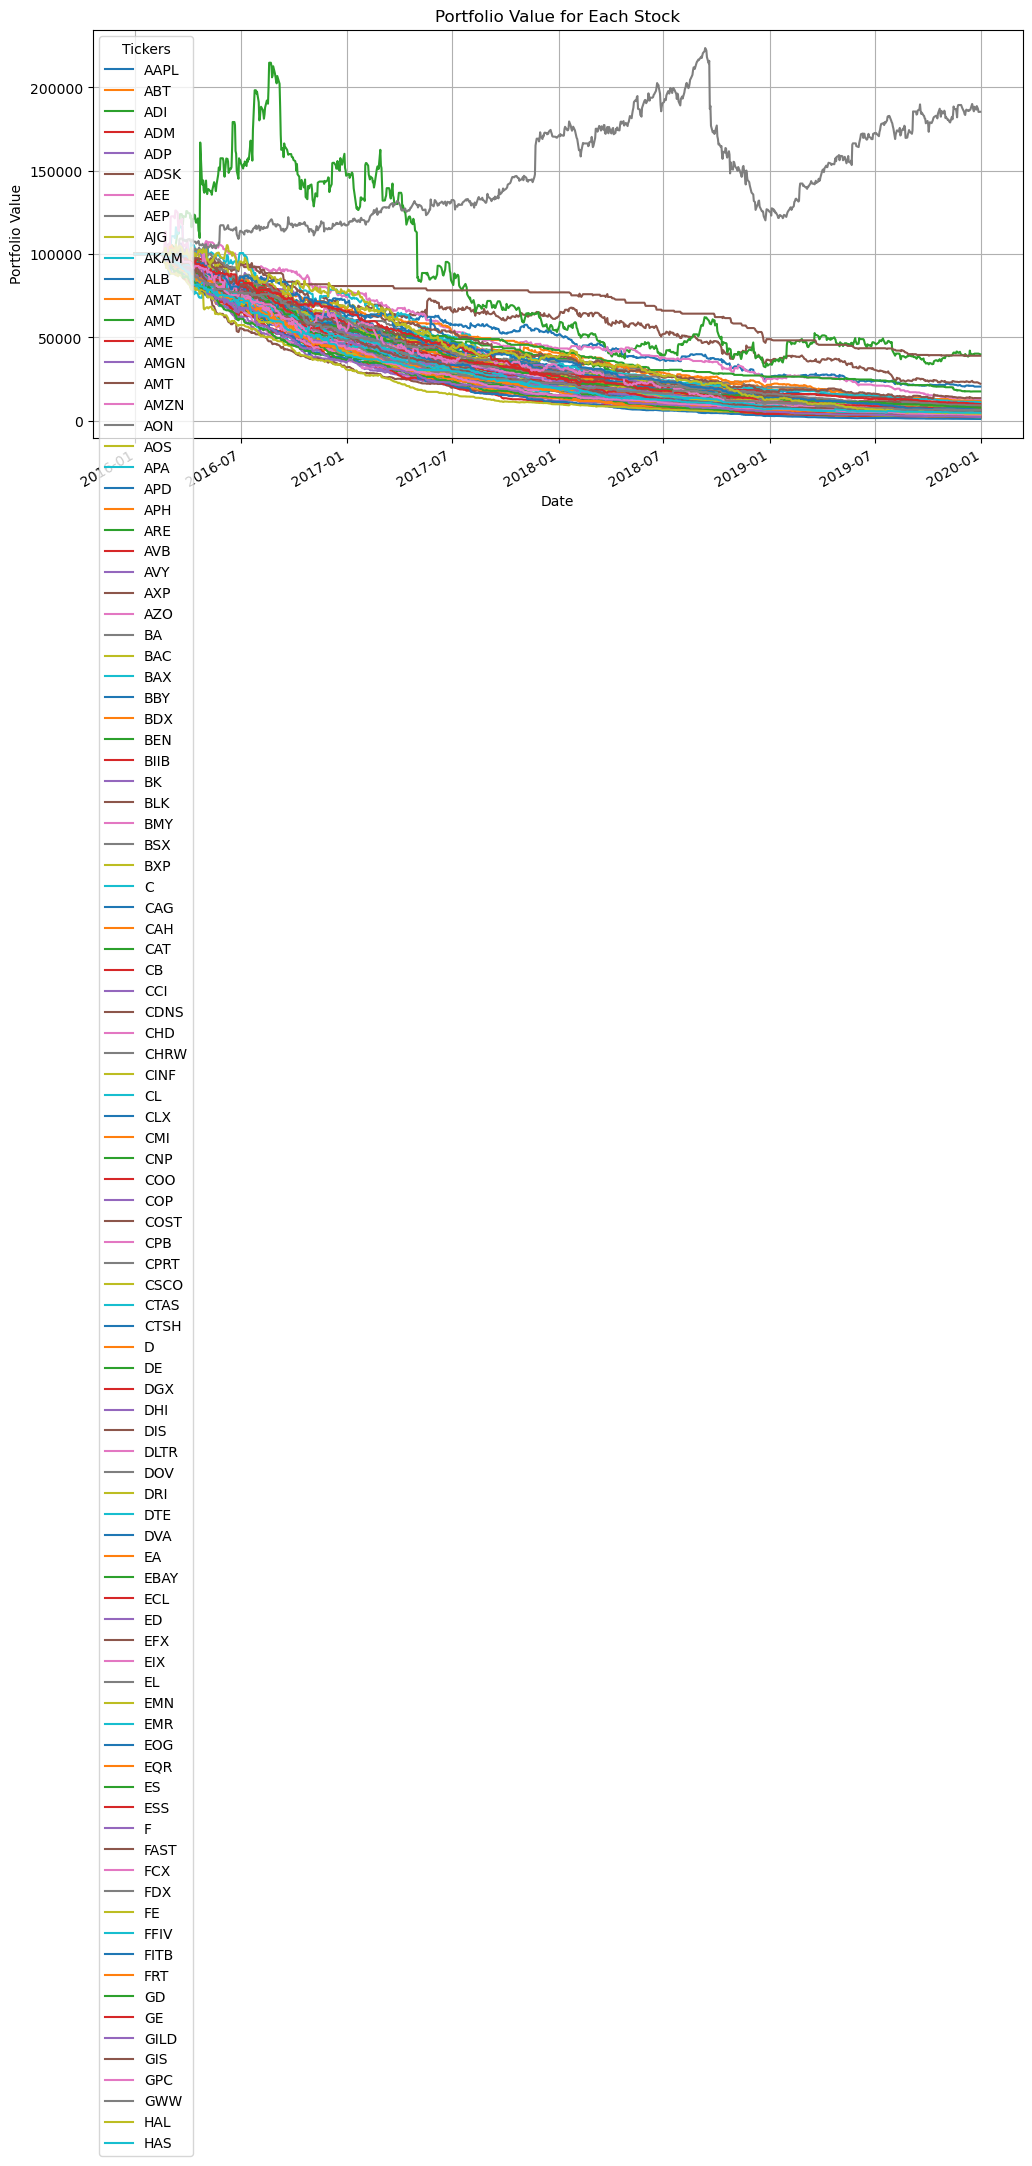

   Ticker   Final Value    Return  Sharpe Ratio  Max Drawdown
0    AAPL  20414.520683 -0.795855     -1.882283     -0.796124
1     ABT   6302.172691 -0.936978     -4.346813     -0.936978
2     ADI   3200.611402 -0.967994     -4.470214     -0.967994
3     ADM   4212.140807 -0.957879     -5.193762     -0.957915
4     ADP   9193.323699 -0.908067     -3.219678     -0.908129
..    ...           ...       ...           ...           ...
95    GIS   4396.598268 -0.956034     -4.776379     -0.956034
96    GPC   3497.754976 -0.965022     -6.197417     -0.965022
97    GWW   6334.073487 -0.936659     -3.616335     -0.936659
98    HAL   4101.308572 -0.958987     -2.729869     -0.961432
99    HAS   4677.457367 -0.953225     -4.408000     -0.953225

[100 rows x 5 columns]


In [17]:
# Optionally, visualize overall performance of all stocks
# Combine all portfolio series
combined_portfolio = pd.concat(portfolio_series_list, axis=1)
combined_portfolio.plot(figsize=(12, 6))
plt.title('Portfolio Value for Each Stock')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend(title='Tickers')
plt.grid(True)
plt.show()

# Display summary of performance metrics
performance_df = pd.DataFrame(performance_summary)
print(performance_df)

In [18]:
performance_df.sort_values("Sharpe Ratio")

,Ticker,Final Value,Return,Sharpe Ratio,Max Drawdown
61,D,2302.681853,-0.976973,-7.874402,-0.976973
44,CCI,2131.544862,-0.978685,-6.794292,-0.978685
63,DGX,1483.915316,-0.985161,-6.626570,-0.985161
91,FRT,2200.764140,-0.977992,-6.495140,-0.977992
81,EQR,2718.940607,-0.972811,-6.373158,-0.972835
...,...,...,...,...,...
0,AAPL,20414.520683,-0.795855,-1.882283,-0.796124
86,FCX,4550.752473,-0.954492,-1.619465,-0.967855
5,ADSK,22148.601686,-0.778514,-1.258984,-0.785836
12,AMD,39787.432620,-0.602126,-0.156057,-0.850856


In [20]:
# Create DataFrame
perf_df = pd.DataFrame(performance_summary)

# Summary statistics
print("\n=== Summary Statistics ===")
print(perf_df.describe().round(4))

# Mean values
mean_metrics = perf_df[['Return', 'Sharpe Ratio', 'Final Value', 'Max Drawdown']].mean()
print("\n=== Mean Metrics ===")
print(mean_metrics.round(4))


=== Summary Statistics ===
       Final Value    Return  Sharpe Ratio  Max Drawdown
count     100.0000  100.0000      100.0000      100.0000
mean     7828.8187   -0.9217       -4.4230       -0.9382
std     18922.4068    0.1892        1.3826        0.0697
min       986.4142   -0.9901       -7.8744       -0.9901
25%      3079.9412   -0.9692       -5.3801       -0.9708
50%      4496.7097   -0.9550       -4.5096       -0.9569
75%      6410.4899   -0.9359       -3.7454       -0.9364
max    185320.2466    0.8532        0.7999       -0.4625

=== Mean Metrics ===
Return            -0.9217
Sharpe Ratio      -4.4230
Final Value     7828.8187
Max Drawdown      -0.9382
dtype: float64


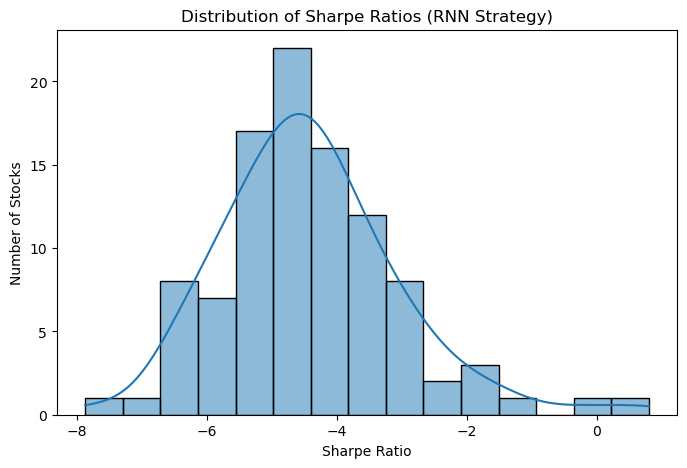

In [21]:
plt.figure(figsize=(8, 5))
sns.histplot(perf_df['Sharpe Ratio'], kde=True, bins=15)
plt.title('Distribution of Sharpe Ratios (RNN Strategy)')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Number of Stocks')
plt.show()


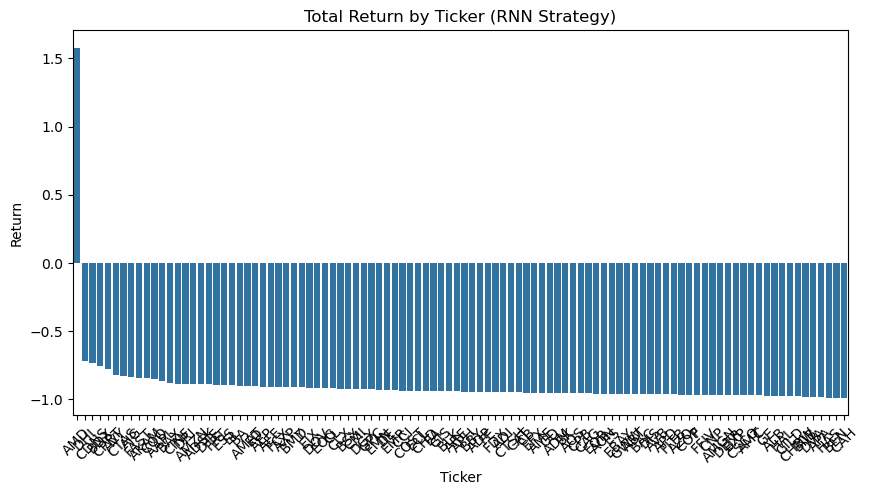

In [36]:
plt.figure(figsize=(10, 5))
sorted_df = perf_df.sort_values(by='Return', ascending=False)
sns.barplot(x='Ticker', y='Return', data=sorted_df)
plt.title('Total Return by Ticker (RNN Strategy)')
plt.ylabel('Return')
plt.xticks(rotation=45)
plt.show()


In [42]:
perf_df.to_csv('rnn_backtest_results.csv', index=False)
cumulative_df.to_csv('rnn_portfolio_timeseries.csv')
